Bibliotecas a usar:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings("ignore")

Carga y visualización del dataset:

In [ ]:
df = pd.read_csv('city_day.csv')

In [ ]:
df.describe()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
count,24933.000000,18391.000000,25949.000000,25946.000000,25346.000000,19203.000000,27472.000000,25677.000000,25509.000000,23908.000000,21490.000000,11422.000000,24850.000000
mean,67.450578,118.127103,17.574730,28.560659,32.309123,23.483476,2.248598,14.531977,34.491430,3.280840,8.700972,3.070128,166.463581
std,64.661449,90.605110,22.785846,24.474746,31.646011,25.684275,6.962884,18.133775,21.694928,15.811136,19.969164,6.323247,140.696585
min,0.040000,0.010000,0.020000,0.010000,0.000000,0.010000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,13.000000
25%,28.820000,56.255000,5.630000,11.750000,12.820000,8.580000,0.510000,5.670000,18.860000,0.120000,0.600000,0.140000,81.000000
50%,48.570000,95.680000,9.890000,21.690000,23.520000,15.850000,0.890000,9.160000,30.840000,1.070000,2.970000,0.980000,118.000000
75%,80.590000,149.745000,19.950000,37.620000,40.127500,30.020000,1.450000,15.220000,45.570000,3.080000,9.150000,3.350000,208.000000
max,949.990000,1000.000000,390.680000,362.210000,467.630000,352.890000,175.810000,193.860000,257.730000,455.030000,454.850000,170.370000,2049.000000


Preprocesamiento de los datos:

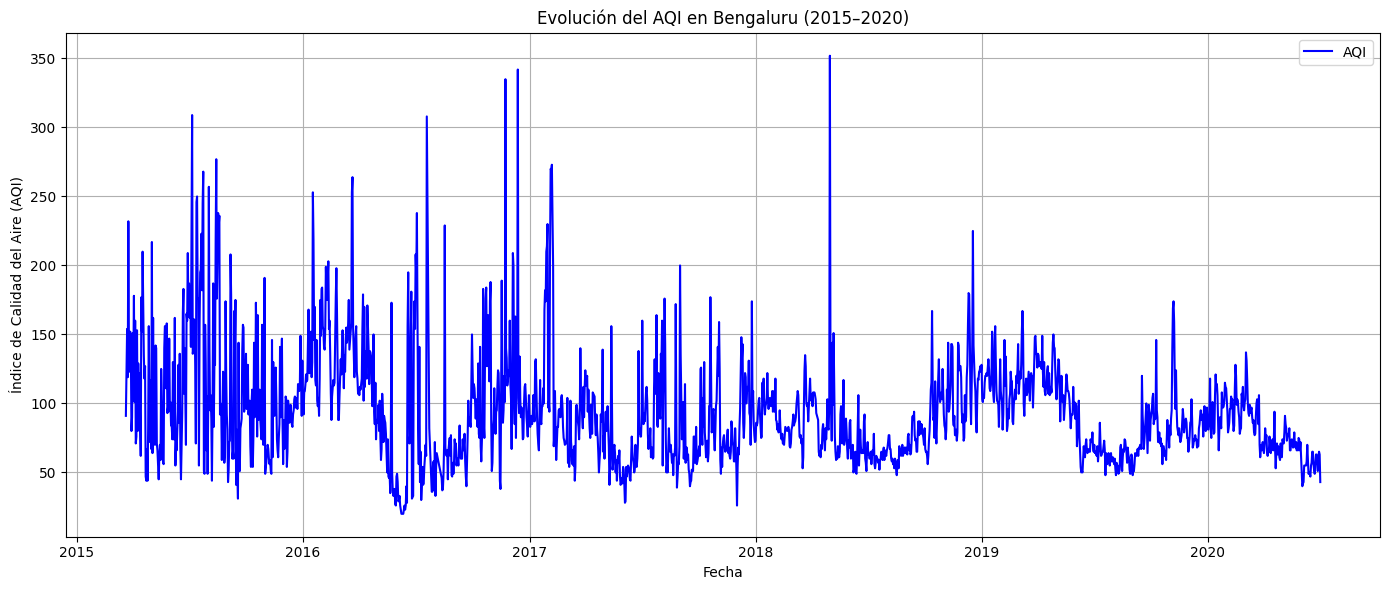

In [ ]:
# Cargar y preparar los datos

df['Date'] = pd.to_datetime(df['Date'])
bengaluru_df = df[df['City'] == 'Bengaluru'][['Date', 'AQI']]
bengaluru_df['AQI'] = pd.to_numeric(bengaluru_df['AQI'], errors='coerce')
bengaluru_df = bengaluru_df.dropna().sort_values('Date').set_index('Date')

# Graficar la serie temporal de AQI en Bengaluru después de limpiar y ordenar
plt.figure(figsize=(14, 6))
plt.plot(bengaluru_df.index, bengaluru_df['AQI'], color='blue', label='AQI')
plt.title('Evolución del AQI en Bengaluru (2015–2020)')
plt.xlabel('Fecha')
plt.ylabel('Índice de Calidad del Aire (AQI)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Prueba de Estacionariedad (Dickey-Fuller)

In [ ]:
adf_result = adfuller(bengaluru_df['AQI'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-valor: {adf_result[1]}')  # p-valor = 1.11e-07

ADF Statistic: -6.077777770177216
p-valor: 1.1108572405973835e-07


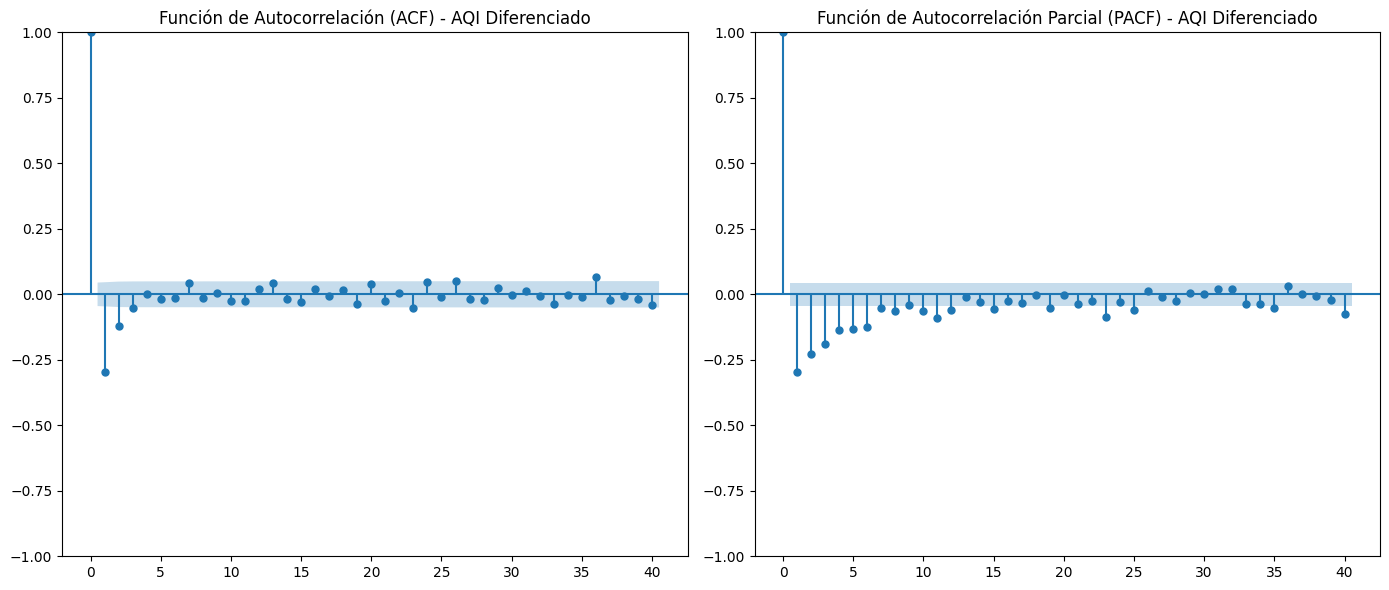

In [ ]:
# Volver a calcular la serie diferenciada (d=1) para asegurar estacionariedad antes de ACF y PACF
diff_series = bengaluru_df['AQI'].diff().dropna()

# Graficar ACF y PACF
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_acf(diff_series, ax=plt.gca(), lags=40)
plt.title('Función de Autocorrelación (ACF) - AQI Diferenciado')

plt.subplot(1, 2, 2)
plot_pacf(diff_series, ax=plt.gca(), lags=40, method='ywm')
plt.title('Función de Autocorrelación Parcial (PACF) - AQI Diferenciado')

plt.tight_layout()
plt.show()

Diferenciación de la Serie

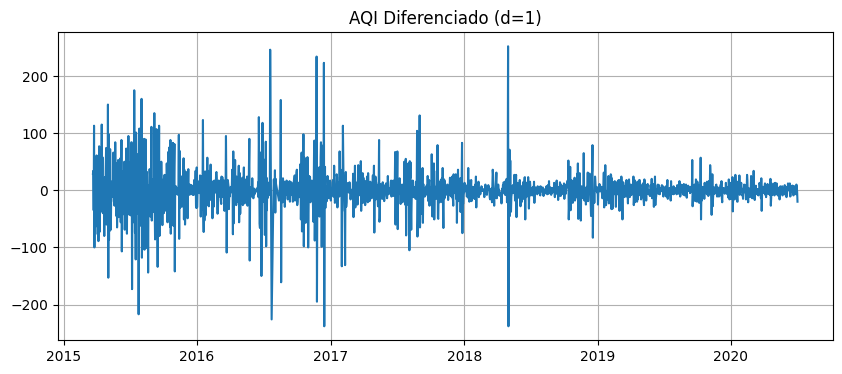

In [ ]:
differenced = bengaluru_df['AQI'].diff().dropna()
plt.figure(figsize=(10, 4))
plt.plot(differenced)
plt.title('AQI Diferenciado (d=1)')
plt.grid(True)
plt.show()

Estimación - Ajuste del modelo ARIMA:

In [ ]:
# Ajuste del modelo ARIMA(2,1,2)
model = ARIMA(bengaluru_df['AQI'], order=(2, 1, 2))
model_fit = model.fit()

# Resumen del modelo
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    AQI   No. Observations:                 1910
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -9188.832
Date:                Mon, 14 Apr 2025   AIC                          18387.664
Time:                        00:48:44   BIC                          18415.436
Sample:                             0   HQIC                         18397.885
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2947      2.527     -0.117      0.907      -5.248       4.659
ar.L2          0.2957      1.035      0.286      0.775      -1.732       2.323
ma.L1         -0.2103      2.530     -0.083      0.9

Validación - Analisis de los residuos del modelo y calculo el error cuadrático medio:

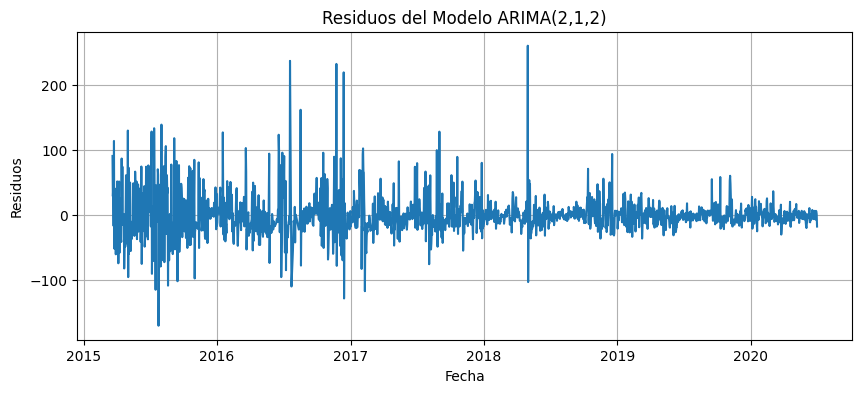

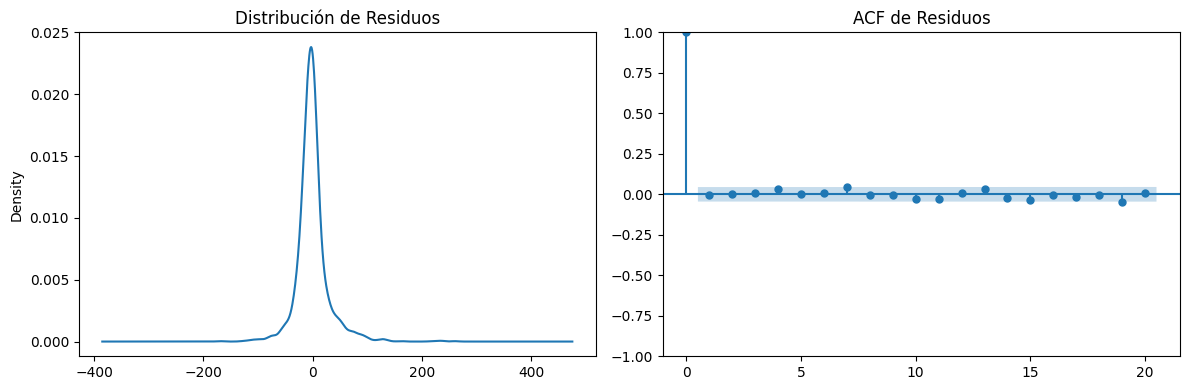



RMSE: 9.114006124280083


In [ ]:
residuals = model_fit.resid

# Gráfico de residuos
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuos del Modelo ARIMA(2,1,2)')
plt.xlabel('Fecha')
plt.ylabel('Residuos')
plt.grid(True)
plt.show()

print("\n")

# Histograma y ACF de residuos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
residuals.plot(kind='kde', ax=ax1, title='Distribución de Residuos')
plot_acf(residuals, lags=20, ax=ax2, title='ACF de Residuos')
plt.tight_layout()
plt.show()

# Calcular RMSE
forecast = model_fit.predict(start=1500, end=1600, typ='levels')
true = bengaluru_df['AQI'].iloc[1500:1601]
print("\n")
print("RMSE:", np.sqrt(mean_squared_error(true, forecast)))

Prueba de Ljung-Box

In [ ]:
lb_test = acorr_ljungbox(residuals, lags=10, return_df=True)
print(lb_test)

     lb_stat  lb_pvalue
1   0.003556   0.952448
2   0.004588   0.997709
3   0.081403   0.993972
4   2.065355   0.723740
5   2.084669   0.837310
6   2.155894   0.904817
7   6.455492   0.487680
8   6.488330   0.592702
9   6.531325   0.685786
10  8.465264   0.583488


División Entrenamiento/Prueba y Validación

In [ ]:
# Dividir datos en entrenamiento y prueba
train = bengaluru_df['AQI'][:1600]
test = bengaluru_df['AQI'][1600:]

# Ajustar modelo y pronosticar
model = ARIMA(train, order=(2,1,2))
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f'RMSE: {rmse}')  # Ejemplo: RMSE ≈ 45.3

RMSE: 27.02433121099317


Pronóstico de los próximos 30 días:

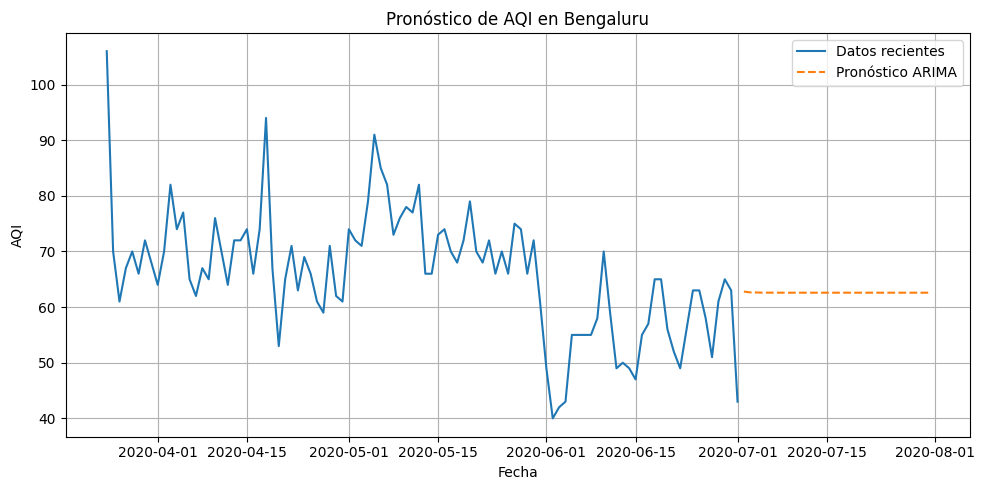

In [ ]:
# Pronóstico de los próximos 30 días
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps)

# Graficar pronóstico
plt.figure(figsize=(10, 5))
plt.plot(bengaluru_df.index[-100:], bengaluru_df['AQI'][-100:], label='Datos recientes')
plt.plot(pd.date_range(bengaluru_df.index[-1], periods=forecast_steps + 1, freq='D')[1:],
         forecast, label='Pronóstico ARIMA', linestyle='--')
plt.title('Pronóstico de AQI en Bengaluru')
plt.xlabel('Fecha')
plt.ylabel('AQI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
forecast = model_fit.forecast(steps=30)
print(forecast)

1600    62.786511
1601    62.645873
1602    62.627129
1603    62.592335
1604    62.597507
1605    62.585919
1606    62.590928
1607    62.586070
1608    62.588988
1609    62.586703
1610    62.588237
1611    62.587113
1612    62.587896
1613    62.587335
1614    62.587731
1615    62.587449
1616    62.587649
1617    62.587507
1618    62.587607
1619    62.587536
1620    62.587587
1621    62.587551
1622    62.587576
1623    62.587558
1624    62.587571
1625    62.587562
1626    62.587568
1627    62.587564
1628    62.587567
1629    62.587565
Name: predicted_mean, dtype: float64
